<a href="https://colab.research.google.com/github/sailusha584/Exploratory-data-Analysis/blob/main/Model_2_ALS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model-2: Matrix factorizartion-Alternating Least Squares

In [2]:
#
# Packages used
# pyspark :It is a package developed to integrate Apache Spark with python.
# This definition of Apache Spark is based on Yogesh Kumar gupta
# Apache Spark is technology used in open-source in memory clusters to increasing the processing of the code computations.

In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
#Installed pyspark package

In [3]:
pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.3 MB 42 kB/s 
     |████████████████████████████████| 199 kB 60.6 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.0-py2.py3-none-any.whl size=281764026 sha256=81f67081ce62460995215f304d7a94db6c2f225cdfb96da45c5250bbce5b48b8
  Stored in directory: /root/.cache/pip/wheels/7a/8e/1b/f73a52650d2e5f337708d9f6a1750d451a7349a867f928b885
Successfully built pyspark


In [ ]:
import os
import time

# spark imports
from pyspark.sql import SparkSession
from pyspark.sql.functions import  explode, desc
from pyspark.sql.types import StringType, ArrayType
from pyspark.mllib.recommendation import ALS

# data science imports
import math
import numpy as np
import pandas as pd

# visualization imports
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [ ]:
# created path  configuration to extract data using spark commands
data_path = os.path.join(os.environ['DATA_PATH'], 'GoodreadBooks')

In [4]:
#@title Reloading data from CSV files
#@markdown Reloading dataset in this notebook as the extracting format of data is different 

In [ ]:
##read book and ratings data 
books = spark.read.load(os.path.join(data_path, 'books_preprocess_13_july.csv'), format='csv', header=True, inferSchema=True)
ratings = spark.read.load(os.path.join(data_path, 'ratings.csv'), format='csv', header=True, inferSchema=True)

In [ ]:
#displaying the first 5 rows of books dataset
books.show(5)

+--------------------+--------------+-------+-----------+--------------------+-----------------+--------------------+-------------+-------------------------+-----+-----------+---------+---------+---------+---------+---------+--------------------+
|             authors|average_rating|book_id|books_count|              genres|goodreads_book_id|           image_url|language_code|original_publication_year|pages|publishDate|ratings_1|ratings_2|ratings_3|ratings_4|ratings_5|               title|
+--------------------+--------------+-------+-----------+--------------------+-----------------+--------------------+-------------+-------------------------+-----+-----------+---------+---------+---------+---------+---------+--------------------+
| ['Suzanne Collins']|          4.34|      1|        272|['young-adult', '...|          2767052|https://images.gr...|          eng|                     2008|  374|   09/14/08|    66715|   127936|   560092|  1481305|  2706317|The Hunger Games ...|
|['J.K. Rowl

In [ ]:
ratings.show(5)

+-------+-------+------+
|user_id|book_id|rating|
+-------+-------+------+
|      1|    258|     5|
|      2|   4081|     4|
|      2|    260|     5|
|      2|   9296|     5|
|      2|   2318|     3|
+-------+-------+------+
only showing top 5 rows



In [ ]:
##Analysing the distinct ratings in the entire dataset
print('Distinct values of ratings:')
print(sorted(ratings.select('rating').distinct().rdd.map(lambda r: r[0]).collect()))

Distinct values of ratings:
['1', '2', '3', '4', '5']


In [ ]:
##Finding the minimum ratings given by user 
tmp1 = ratings.groupBy("user_id").count().toPandas()['count'].min()
tmp2 = ratings.groupBy("book_id").count().toPandas()['count'].min()
print('For the users that rated books and the books that were rated:')
print('Minimum number of ratings per user is {}'.format(tmp1))
print('Minimum number of ratings per book is {}'.format(tmp2))

For the users that rated books and the books that were rated:
Minimum number of ratings per user is 19
Minimum number of ratings per book is 8


In [ ]:
#distinct users in ratings
tmp = ratings.select('user_id').distinct().count()
print('We have a total of {} distinct users in the data sets'.format(tmp))

We have a total of 53424 distinct users in the data sets


In [ ]:
##distinct books from preprocessed books csv file
tmp = books.select('book_id').distinct().count()
print('We have a total of {} distinct books in the data sets'.format(tmp))

We have a total of 9964 distinct books in the data sets


In [ ]:
##Alternative implementation of ALS from blog :
#https://towardsdatascience.com/build-recommendation-system-with-pyspark-using-alternating-least-squares-als-matrix-factorisation-ebe1ad2e7679

In [ ]:
#Import the libraries for modelling
import pandas as pd
from pyspark.sql.functions import col, explode
from pyspark import SparkContext
from pyspark.ml.tuning import CrossValidatorModel
from pyspark.ml.tuning import TrainValidationSplit

In [ ]:
##Created a spark session
from pyspark.sql import SparkSession
sc = SparkContext
# sc.setCheckpointDir('checkpoint')
spark = SparkSession.builder.appName('Recommendations').getOrCreate()

In [ ]:
##Mounted google drive to access drive 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
#@title Train-Validation-Test-Split
#@markdown Created Train-Test Split to reduce overfitting and also to reproduce cold start scenarios

In [ ]:
# Create train, validation and test set with 80-10-10 split 
(train_otherset, validation_otherset, test_otherset) = ratings.randomSplit([0.8, 0.1, 0.1], seed = 234)

In [ ]:
# Created train, validation and test set   with 60-20-20 split 
(train, validation, test) = ratings.randomSplit([0.6, 0.2, 0.2], seed = 1234)

In [ ]:
##writing the data to csv files
train_otherset.write.csv('/content/drive/MyDrive/saved_data/train.csv')
validation_otherset.write.csv('/content/drive/MyDrive/saved_data/validation.csv')
test_otherset.write.csv('/content/drive/MyDrive/saved_data/test.csv')

In [ ]:
##Loading already created train-validation-test files to have same data even after multiple runs
train_ratings=spark.read.csv('/content/drive/MyDrive/saved_data/train.csv',inferSchema=True)
validation_ratings=spark.read.csv('/content/drive/MyDrive/saved_data/validation.csv',inferSchema=True)
test_ratings=spark.read.csv('/content/drive/MyDrive/saved_data/test.csv',inferSchema=True)

In [ ]:
#@markdown Loading first few rows of validation ,test rows to check headers of the dataframe

In [ ]:

validation_ratings.head()

Row(_c0=1, _c1=13, _c2=4.0)

In [ ]:
##renamed the ratings dataframe columns to more understandable name 
validation_ratings=validation_ratings.withColumnRenamed("_c0","user_id").withColumnRenamed("_c1","book_id").withColumnRenamed("_c2","rating")

In [ ]:
#read first few rows
test_ratings.head()

Row(_c0=1, _c1=35, _c2=5.0)

In [ ]:
##read first few rows of test ratings file
test_ratings=test_ratings.withColumnRenamed("_c0","user_id").withColumnRenamed("_c1","book_id").withColumnRenamed("_c2","rating")

In [ ]:
test_ratings.head()

Row(user_id=1, book_id=35, rating=5.0)

In [ ]:
##converted the datatype of ratings from double to float 
validation_ratings = validation_ratings.\
    withColumn('rating', col('rating').cast('float'))

In [ ]:
##converted the datatype of ratings from double to float 
test_ratings = validation_ratings.\
    withColumn('rating', col('rating').cast('float'))

In [ ]:
validation_ratings.show()

+-------+-------+------+
|user_id|book_id|rating|
+-------+-------+------+
|      1|     13|   4.0|
|      1|     22|   3.0|
|      1|     57|   3.0|
|      1|     60|   3.0|
|      1|     94|   1.0|
|      1|    132|   3.0|
|      1|    140|   3.0|
|      1|    179|   2.0|
|      1|    216|   3.0|
|      1|    233|   4.0|
|      1|    354|   3.0|
|      1|   3406|   2.0|
|      2|     33|   4.0|
|      2|    264|   3.0|
|      3|     28|   2.0|
|      3|    101|   1.0|
|      3|    118|   3.0|
|      3|    501|   1.0|
|      3|    531|   2.0|
|      3|    782|   2.0|
+-------+-------+------+
only showing top 20 rows



In [ ]:
#@markdown Finding  the sparsity of user-book  which is one of the important factors to improve the training 

In [ ]:
#@markdown sparsity=1-dense_matrix

#@markdown dense_matrix=No of dense elements% Total no of elements



In [ ]:
 # Calculate the total number of ratings in the dataset
divisor = ratings.select("rating").count()

# Measure the number of distinct userIds and distinct bookIds
no_users = ratings.select("user_id").distinct().count()
no_books = ratings.select("book_id").distinct().count()

# assign the denominator equal to the number of users multiplied by the number of books
denomin = no_users * no_books

# Divide the divisor by the denominator
sparsity = (1.0 - (divisor *1.0)/denomin)*100
print("The ratings dataframe is ", "%.2f" % sparsity + "% empty.")

The ratings dataframe is  98.88% empty.


In [ ]:
# Import the required functions for modelling 
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

In [ ]:

# Create ALS model
model_als = ALS(userCol="user_id", itemCol="book_id", ratingCol="rating", nonnegative = True, implicitPrefs = False, coldStartStrategy="drop")

# Confirm that a model called "als" was created
type(model_als)

pyspark.ml.recommendation.ALS

In [9]:
#@markdown Model ALS was generated using the parameters \
 #@markdown user_id column \
#@markdown book_id column\
#@markdown rating column -with no negative values as all ratings are postive\
#@markdown The data considered is not implicit data so implicitPrefs is set to True \
#@markdown Cold start scenario will return na values if the the row is not available

In [ ]:
##Rank represents number of latent factors 
##Regularization parameter represents

In [ ]:
rank_params=[60,50,40]
reg_params=[0.01,0.1]
##No of iterations are by default 10 in the function parmGrid Builder

In [ ]:
# Import the requisite items
from pyspark.ml.evaluation import RegressionEvaluator,RankingEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator


# Add parameters and their respective values to param_matrix
param_matrix = ParamGridBuilder() \
            .addGrid(model_als.rank,[rank_params[1]]) \
            .addGrid(model_als.regParam,[reg_params[0]]) \
            .build()

           
# Define evaluator as RMSE and print length of evaluator
evaluator_regres= RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction") 
print ("Num models to be tested: ", len(param_matrix))

Num models to be tested:  1


In [ ]:
#@markdown Models are run individually with different parameters and not in loop because it is computational expensive (google colab disconnects after 90 minutes or kernel dies if too many models are run)

In [ ]:
# Import the requisite items
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Add hyperparameters and their respective values to param_grid
param_matrix = ParamGridBuilder() \
            .addGrid(model_als.rank, [rank_params[0]]) \
            .addGrid(model_als.regParam,[reg_params[1]]) \
            .build()
            #             .addGrid(als.maxIter, [5, 50, 100, 200]) \

           


In [ ]:
# Define evaluator with RMSE as metric and no of models are printed
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction") 
print ("Num models to be tested: ", len(param_matrix))

In [ ]:
# Import the requisite items
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Add hyperparameters and their respective values to param_matrix
param_matrix = ParamGridBuilder() \
            .addGrid(model_als.rank, [rank_params[0]]) \
            .addGrid(model_als.regParam, [reg_params[0]]) \
            .build()

           
# Define evaluator with RMSE as metric and no of models are printed
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction") 
print ("Num models to be tested: ", len(param_matrix))

Num models to be tested:  1


In [ ]:
# Import the requisite items
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Add hyperparameters and their respective values to param_matrix
param_matrix = ParamGridBuilder() \
            .addGrid(model_als.rank, [rank_params[2]]) \
            .addGrid(model_als.regParam,[reg_params[1]]) \
            .build()

# Define evaluator with RMSE as metric and no of models are printed
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction") 
print ("Num models to be tested: ", len(param_matrix))

Num models to be tested:  1


In [ ]:
# cross validation by CrossValidator
cv = CrossValidator(estimator=model_als, estimatorParamMaps=param_matrix, evaluator=evaluator, numFolds=5)

# Confirm cv was built
print(cv)

CrossValidator_deea7f38fc5a


In [ ]:
#@title Fit the models, save them and reload them


In [ ]:
temp_path='/content/drive/MyDrive/models'

In [ ]:
#Fit cross validator for training
model_1 = cv.fit(train_otherset)

#Get best model from the cv model
good_model_1 = model_1.bestModel
model1_path = temp_path + "/als_model_2"
good_model_1.save(model1_path)

In [ ]:
#Fit cross validator for training
model_2 = cv.fit(train_otherset)

#Get best model from the cv model
good_model_2 = model_2.bestModel
model2_path = temp_path + "/als_model_2"
good_model_2.save(model2_path)

In [ ]:
#Fit cross validator for training
model_3 = cv.fit(train_otherset)

#Get best model from the cv model
good_model_3 = model_3.bestModel
model3_path = temp_path + "/als_model_3"
good_model_3.save(model3_path)

In [ ]:
#Fit cross validator for training
model_4 = cv.fit(train_otherset)

#Get best model from the cv model
good_model_4 = model_4.bestModel
model4_path = temp_path + "/als_model_4"
good_model_4.save(model4_path)

In [ ]:
#@title Re-Loading the models

In [ ]:
#first model 
from pyspark.ml.recommendation import ALSModel

model_50 = ALSModel.load("/content/drive/MyDrive/models/als_model")

In [ ]:
from pyspark.ml.recommendation import ALSModel

model_60_01 = ALSModel.load("/content/drive/MyDrive/models/als_model_2")

In [ ]:
from pyspark.ml.recommendation import ALSModel

model_60_001 = ALSModel.load("/content/drive/MyDrive/models/als_model_3")

In [ ]:
from pyspark.ml.recommendation import ALSModel

model_40_01 = ALSModel.load("/content/drive/MyDrive/models/als_model_4")

In [ ]:
##creating two lists to add rmse to that lists
RMSE_validations=[]
RMSE_test=[]


In [ ]:
##Predictions using evaluator for metric RMSE for rank=50, reg=0.01
validate_predictions = model_50.transform(validation_ratings)
RMSE_validations.append(evaluator.evaluate(validate_predictions))
test_pred = model_50.transform(test_ratings)
RMSE_test.append(evaluator.evaluate(test_pred))

In [ ]:
##Predictions for rank=60, reg=0.1
validate_predictions = model_60_01.transform(validation_ratings)
RMSE_validations.append(evaluator.evaluate(validate_predictions))
test_pred = model_60_01.transform(test_ratings)
RMSE_test.append(evaluator.evaluate(test_pred))

In [ ]:
##Predictions for rank=60, reg=0.01
validate_predictions = model_60_001.transform(validation_ratings)
RMSE_validations.append(evaluator.evaluate(validate_predictions))
test_pred = model_60_001.transform(test_ratings)
RMSE_test.append(evaluator.evaluate(test_pred))

In [ ]:
##Predictions for rank=40, reg=0.1
validate_predictions = model_40_01.transform(validation_ratings)
RMSE_validations.append(evaluator.evaluate(validate_predictions))
test_pred = model_40_01.transform(test_ratings)
RMSE_test.append(evaluator.evaluate(test_pred))

In [ ]:
RMSE_validations

[0.9216080380803043,
 0.8212674431928401,
 0.9294209713259305,
 0.8230285104522589]

In [ ]:
RMSE_test

[0.9216080380803043,
 0.8212674431928401,
 0.9294209713259305,
 0.8230285104522589]

In [ ]:
model_names=['model-50-0.01','model-60-0.1','model-60-0.01','model-40-0.1']

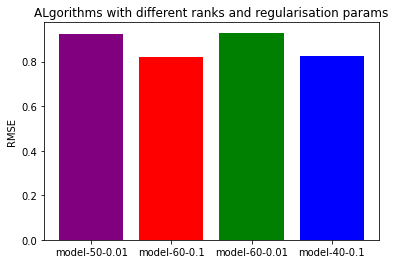

In [ ]:
from matplotlib.pyplot import xlim
import matplotlib.pyplot as plt
import numpy as np
x_pos = np.arange(len(model_names))
plt.bar(model_names,RMSE_validations,color=['purple', 'red', 'green', 'blue', 'cyan'])
plt.xticks(x_pos,model_names)
plt.title('ALgorithms with different ranks and regularisation params')
plt.ylabel('RMSE')
plt.show()
#plt.xlabel('Model names  with format (name-no of latent factors-regularisation_params)')

In [ ]:
# Displayed n Recommendations for all users
recommendations = good_model_2.recommendForAllUsers(5)
recommendations.show()

+-------+--------------------+
|user_id|     recommendations|
+-------+--------------------+
|      1|[{8946, 4.5825987...|
|      3|[{464, 2.674022},...|
|      5|[{8946, 4.796386}...|
|      6|[{9537, 5.193078}...|
|      9|[{6920, 4.249055}...|
|     12|[{8946, 4.8706894...|
|     13|[{4868, 5.1269636...|
|     15|[{9842, 5.1204014...|
|     16|[{7063, 4.851418}...|
|     17|[{8946, 5.3222265...|
|     19|[{8946, 4.0324717...|
|     20|[{5990, 4.9759674...|
|     22|[{8946, 4.533051}...|
|     26|[{8946, 4.6841087...|
|     27|[{4868, 4.6853733...|
|     28|[{8946, 4.940489}...|
|     31|[{8946, 4.2108564...|
|     34|[{8946, 4.5941434...|
|     35|[{6920, 3.84977},...|
|     37|[{8946, 5.3904037...|
+-------+--------------------+
only showing top 20 rows



In [ ]:
n_recommend = recommendations\
    .withColumn("rec_exp", explode("recommendations"))\
    .select('user_id', col("rec_exp.book_id"), col("rec_exp.rating"))


+-------+--------------------+
|user_id|     recommendations|
+-------+--------------------+
|      1|[{8946, 4.5825987...|
|      3|[{464, 2.674022},...|
|      5|[{8946, 4.796386}...|
|      6|[{9537, 5.193078}...|
|      9|[{6920, 4.249055}...|
|     12|[{8946, 4.8706894...|
|     13|[{4868, 5.1269636...|
|     15|[{9842, 5.1204014...|
|     16|[{7063, 4.851418}...|
|     17|[{8946, 5.3222265...|
+-------+--------------------+



In [ ]:
#showing top 10 recommendations for user_id=1
n_recommend.limit(10).show()

+-------+-------+---------+
|user_id|book_id|   rating|
+-------+-------+---------+
|      1|   8946|4.5825987|
|      1|   7947|4.4613237|
|      1|   3628|4.3915706|
|      1|   9566|4.3506875|
|      1|   6920|4.3174577|
|      3|    464| 2.674022|
|      3|   4090|2.5850894|
|      3|   6618|2.4757845|
|      3|   7499|2.4717994|
|      3|   4376|2.4188144|
+-------+-------+---------+



In [ ]:
## Recommendations for given input title

In [1]:
name=input('Enter input title:')

Enter input title:Poisonwood bible


In [ ]:
#This method is for personalised recommendations with user_id =100
nrecommendations.join(books, on='book_id').filter('title ='%name ).show()

+-------+-------+---------+--------------------+--------------+-----------+--------------------+-----------------+--------------------+-------------+-------------------------+-----+--------------------+---------+---------+---------+---------+---------+--------------------+
|book_id|user_id|   rating|             authors|average_rating|books_count|              genres|goodreads_book_id|           image_url|language_code|original_publication_year|pages|         publishDate|ratings_1|ratings_2|ratings_3|ratings_4|ratings_5|               title|
+-------+-------+---------+--------------------+--------------+-----------+--------------------+-----------------+--------------------+-------------+-------------------------+-----+--------------------+---------+---------+---------+---------+---------+--------------------+
|   8946|    100| 4.352078|           ['Hafez']|          4.63|         91|['poetry', 'class...|            46292|https://images.gr...|          eng|                     1380|  5

In [ ]:
ratings.join(books, on='book_id').filter('title ='%name ).sort('rating', ascending=False).limit(10).show()

+-------+-------+------+--------------------+--------------+-----------+--------------------+-----------------+--------------------+-------------+-------------------------+-----+--------------------+---------+---------+---------+---------+---------+--------------------+
|book_id|user_id|rating|             authors|average_rating|books_count|              genres|goodreads_book_id|           image_url|language_code|original_publication_year|pages|         publishDate|ratings_1|ratings_2|ratings_3|ratings_4|ratings_5|               title|
+-------+-------+------+--------------------+--------------+-----------+--------------------+-----------------+--------------------+-------------+-------------------------+-----+--------------------+---------+---------+---------+---------+---------+--------------------+
|   8946|    100|   5.0|           ['Hafez']|          4.63|         91|['poetry', 'class...|            46292|https://images.gr...|          eng|                     1380|  566|         